In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [10]:
df=pd.read_csv("BTC-USD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-06-08,8036.774902,8076.891113,7837.610840,7954.127930,7954.127930,16522722810
1,2019-06-09,7949.674805,7975.974121,7583.219727,7688.077148,7688.077148,16610726547
2,2019-06-10,7692.284668,8031.909668,7586.730957,8000.329590,8000.329590,18689275117
3,2019-06-11,8004.243652,8026.394043,7772.803711,7927.714355,7927.714355,17107279932
4,2019-06-12,7925.434082,8196.648438,7862.359863,8145.857422,8145.857422,19034432883


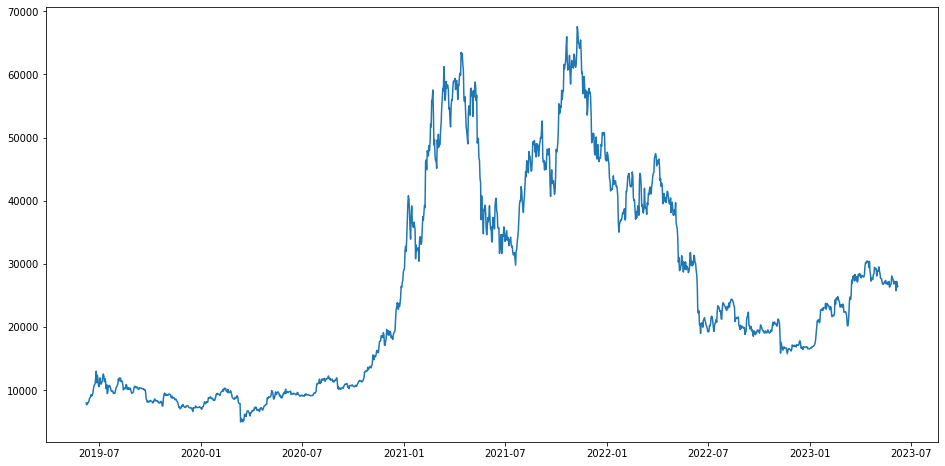

In [11]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [12]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

new_dataset.head()

,Date,Close
0,2019-06-08 00:00:00,7954.12793
1,2019-06-09 00:00:00,7688.077148
2,2019-06-10 00:00:00,8000.32959
3,2019-06-11 00:00:00,7927.714355
4,2019-06-12 00:00:00,8145.857422


In [13]:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
final_dataset=new_dataset.values

train_data=final_dataset[0:1100,:]
valid_data=final_dataset[1100:,:]

scaled_data=scaler.fit_transform(final_dataset)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [14]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

1040/1040 - 22s - loss: 0.0045 - 22s/epoch - 21ms/step


In [15]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

12/12 [==============================] - 1s 15ms/step


In [16]:
lstm_model.save("saved_model.h5")

C:\Users\Admin\AppData\Local\Temp\ipykernel_20244\42576769.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


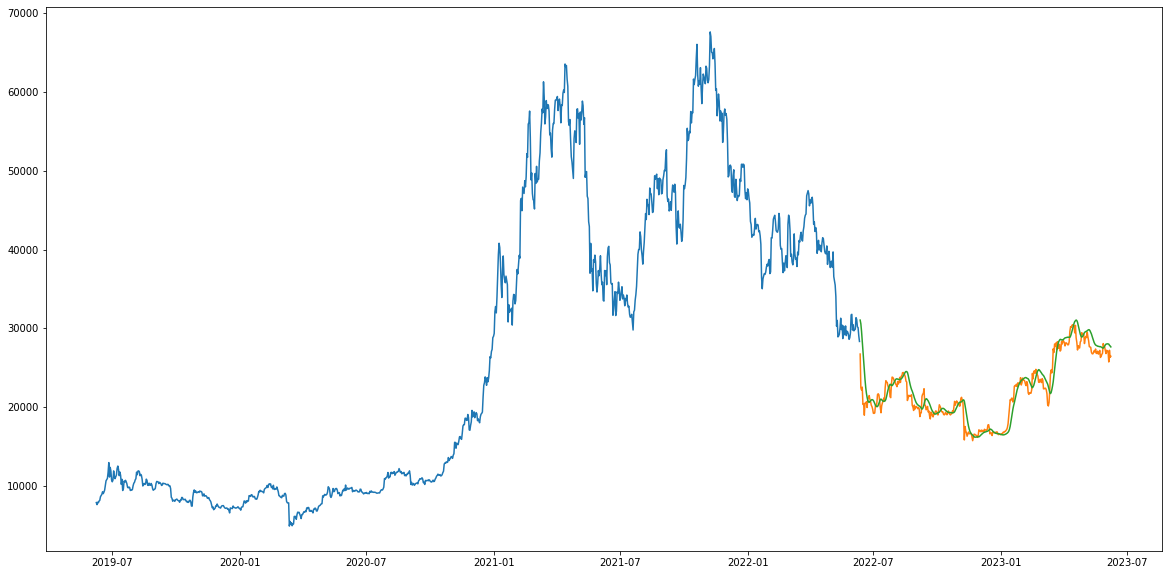

In [18]:
train_data=new_dataset[:1100]
valid_data=new_dataset[1100:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])